In [10]:
!pip install optuna

Starting Pareto Frontier generation (aiming for up to 25 alpha evaluations).
Optuna trials per alpha: 400

--- Evaluating Alpha 1/25: 0.0000 ---
  Best hyperparameters for alpha=0.0000: {'n_estimators': 145, 'learning_rate': 0.17233719624011148, 'max_depth': 10, 'subsample': 0.7669702108562816, 'colsample_bytree': 0.8555452276141284, 'gamma': 0.3634419091988299, 'min_child_weight': 8, 'reg_alpha': 4.718216472007216e-08, 'reg_lambda': 0.4078645135443346}
  Test Set: Accuracy = 0.6392, DPD = 0.1975

--- Evaluating Alpha 2/25: 1.0000 ---
  Best hyperparameters for alpha=1.0000: {'n_estimators': 59, 'learning_rate': 0.012799250084360685, 'max_depth': 6, 'subsample': 0.8199278071247909, 'colsample_bytree': 0.7387947590057773, 'gamma': 0.37982641715770676, 'min_child_weight': 5, 'reg_alpha': 0.006885406639609125, 'reg_lambda': 0.00192614221122526}
  Test Set: Accuracy = 0.6638, DPD = 0.2738
  ADAPTIVE (Midpoint): Added new alpha candidate: 0.5000

--- Evaluating Alpha 3/25: 0.5000 ---
  Best

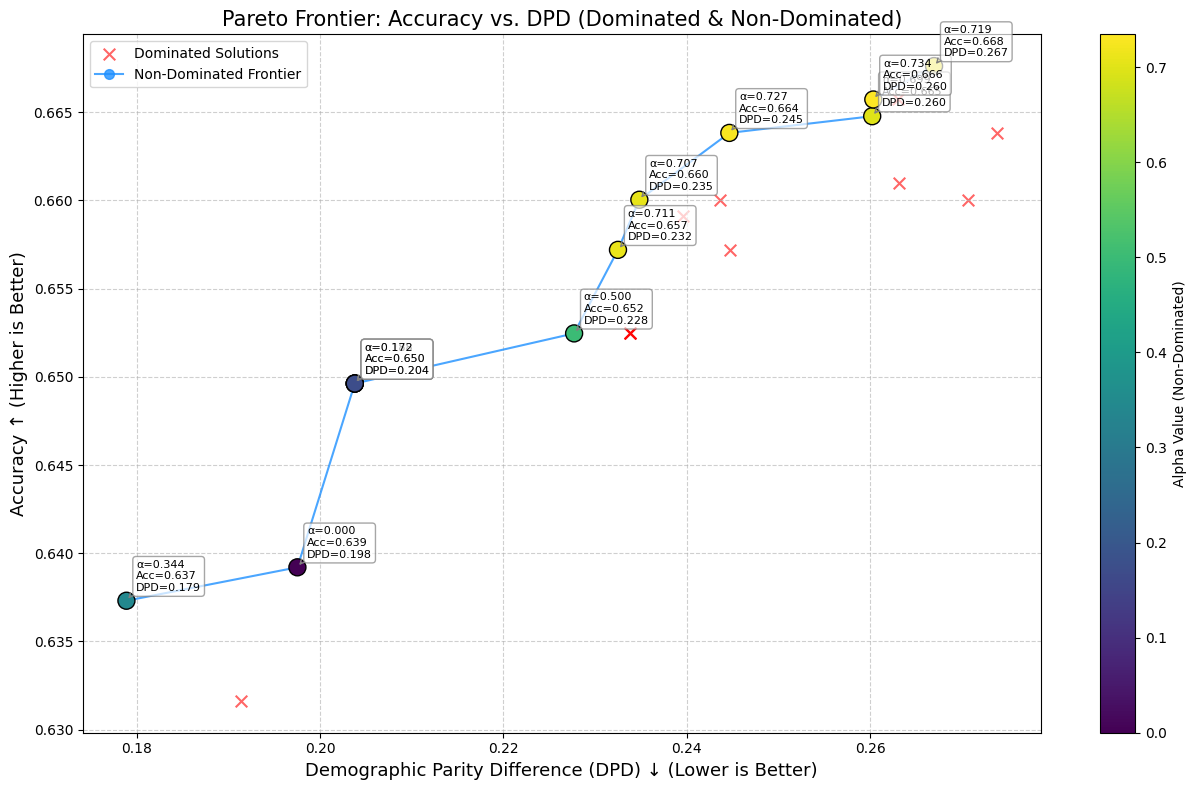


--- Non-Dominated Pareto Frontier Points (Sorted by DPD) ---
Point 1: Alpha=0.3438, Accuracy=0.6373, DPD=0.1789
Point 2: Alpha=0.0000, Accuracy=0.6392, DPD=0.1975
Point 3: Alpha=0.2500, Accuracy=0.6496, DPD=0.2038
Point 4: Alpha=0.1250, Accuracy=0.6496, DPD=0.2038
Point 5: Alpha=0.1875, Accuracy=0.6496, DPD=0.2038
Point 6: Alpha=0.1719, Accuracy=0.6496, DPD=0.2038
Point 7: Alpha=0.5000, Accuracy=0.6525, DPD=0.2277
Point 8: Alpha=0.7109, Accuracy=0.6572, DPD=0.2325
Point 9: Alpha=0.7070, Accuracy=0.6600, DPD=0.2348
Point 10: Alpha=0.7266, Accuracy=0.6638, DPD=0.2446
Point 11: Alpha=0.6992, Accuracy=0.6648, DPD=0.2602
Point 12: Alpha=0.7344, Accuracy=0.6657, DPD=0.2603
Point 13: Alpha=0.7188, Accuracy=0.6676, DPD=0.2670


In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings

# Suppress Optuna's trial logs and other warnings for cleaner output during runs
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- 1. Data Loading and Preprocessing ---
def load_and_preprocess_data():
    """Loads and preprocesses the COMPAS dataset."""
    try:
        df = pd.read_csv('compas-scores-two-years.csv')
    except FileNotFoundError:
        print("Error: 'compas-scores-two-years.csv' not found. Make sure it's in the same directory.")
        return None, None, None, None, None, None

    df = df[
        (df['days_b_screening_arrest'] <= 30) &
        (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) &
        (df['c_charge_degree'] != 'O') &
        (df['score_text'] != 'N/A')
    ]
    df = df[(df['race'] == 'African-American') | (df['race'] == 'Caucasian')]

    features = [
        'sex', 'age', 'age_cat', 'race',
        'juv_fel_count', 'juv_misd_count', 'juv_other_count',
        'priors_count', 'c_charge_degree',
        'days_b_screening_arrest'
    ]
    target = 'two_year_recid'

    if 'days_b_screening_arrest' in features:
        df['days_b_screening_arrest'] = df['days_b_screening_arrest'].fillna(df['days_b_screening_arrest'].median())

    X = df[features]
    y = df[target]

    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()

    if 'race' in numerical_features: # Ensure 'race' is handled as categorical
        numerical_features.remove('race')
        if 'race' not in categorical_features:
             categorical_features.append('race')
        X['race'] = X['race'].astype('category')


    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
        ],
        remainder='passthrough'
    )

    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    sensitive_attribute_test = X_test['race'].copy()

    X_train_full_processed = preprocessor.fit_transform(X_train_full)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_full_processed, y_train_full, X_test_processed, y_test, sensitive_attribute_test, preprocessor

# --- 2. Demographic Parity Difference (DPD) Metric ---
def demographic_parity_difference(y_true, y_pred, sensitive_features, privileged_group_val='Caucasian', unprivileged_group_val='African-American'):
    if not isinstance(sensitive_features, pd.Series):
        sensitive_features = pd.Series(sensitive_features) # Ensure Series for consistent indexing

    df = pd.DataFrame({'true': y_true, 'pred': y_pred, 'sensitive': sensitive_features.values})

    unprivileged_group_df = df[df['sensitive'] == unprivileged_group_val]
    privileged_group_df = df[df['sensitive'] == privileged_group_val]

    ppr_unprivileged = 0.0
    if not unprivileged_group_df.empty:
        ppr_unprivileged = unprivileged_group_df[unprivileged_group_df['pred'] == 1].shape[0] / unprivileged_group_df.shape[0]

    ppr_privileged = 0.0
    if not privileged_group_df.empty:
        ppr_privileged = privileged_group_df[privileged_group_df['pred'] == 1].shape[0] / privileged_group_df.shape[0]

    return abs(ppr_unprivileged - ppr_privileged)


# --- 3. Optuna Objective Function ---
current_alpha_for_optuna = 0.0

def objective(trial, X_train_opt, y_train_opt, X_val_opt, y_val_opt, sensitive_val_opt):
    global current_alpha_for_optuna

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_opt, y_train_opt, verbose=False,
              eval_set=[(X_val_opt, y_val_opt)]) # Re-added early_stopping_rounds

    preds_proba_val = model.predict_proba(X_val_opt)[:, 1]
    preds_binary_val = (preds_proba_val >= 0.5).astype(int)

    acc_val = accuracy_score(y_val_opt, preds_binary_val)
    dpd_val = demographic_parity_difference(y_val_opt, preds_binary_val, sensitive_val_opt)

    return current_alpha_for_optuna * (1 - acc_val) + (1 - current_alpha_for_optuna) * dpd_val

# --- 4. Main Workflow ---
def find_pareto_frontier(max_points=10, n_trials_optuna=25):
    global current_alpha_for_optuna

    load_results = load_and_preprocess_data()
    if load_results[0] is None:
        return [], set() # Return empty list and empty set if data loading fails
    X_train_full_processed, y_train_full, X_test_processed, y_test, sensitive_attribute_test, preprocessor = load_results

    df_orig_for_split = pd.read_csv('compas-scores-two-years.csv')
    df_orig_for_split = df_orig_for_split[
        (df_orig_for_split['days_b_screening_arrest'] <= 30) & (df_orig_for_split['days_b_screening_arrest'] >= -30) &
        (df_orig_for_split['is_recid'] != -1) & (df_orig_for_split['c_charge_degree'] != 'O') & (df_orig_for_split['score_text'] != 'N/A')
    ]
    df_orig_for_split = df_orig_for_split[(df_orig_for_split['race'] == 'African-American') | (df_orig_for_split['race'] == 'Caucasian')]
    features_cols_orig = [
        'sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
        'juv_other_count', 'priors_count', 'c_charge_degree', 'days_b_screening_arrest'
    ]
    X_orig_for_split = df_orig_for_split[features_cols_orig]
    y_orig_for_split = df_orig_for_split['two_year_recid']

    X_train_full_orig, _, _, _ = train_test_split(
        X_orig_for_split, y_orig_for_split, test_size=0.2, random_state=42, stratify=y_orig_for_split
    )

    X_train_opt_indices, X_val_opt_indices = train_test_split(
        np.arange(X_train_full_processed.shape[0]), test_size=0.25, random_state=123, stratify=y_train_full
    )

    X_train_opt = X_train_full_processed[X_train_opt_indices]
    y_train_opt = y_train_full.iloc[X_train_opt_indices]
    X_val_opt = X_train_full_processed[X_val_opt_indices]
    y_val_opt = y_train_full.iloc[X_val_opt_indices]
    sensitive_attribute_opt_val = X_train_full_orig['race'].iloc[X_val_opt_indices]

    alphas_to_evaluate = [0.0, 1.0]
    processed_alphas = set() # This will be returned
    candidate_pareto_points = []

    points_found_count = 0
    while points_found_count < max_points:
        if not alphas_to_evaluate:
            print("Alpha queue is empty, and target number of alpha evaluations not yet reached. Adaptive search did not yield new candidates. Stopping.")
            break

        current_alpha_for_optuna = alphas_to_evaluate.pop(0)

        if current_alpha_for_optuna in processed_alphas:
            print(f"Alpha {current_alpha_for_optuna:.4f} was already processed. Skipping.")
            continue

        print(f"\n--- Evaluating Alpha {points_found_count + 1}/{max_points}: {current_alpha_for_optuna:.4f} ---")

        processed_alphas.add(current_alpha_for_optuna) # Add to processed_alphas before Optuna study

        # User-specified NSGAIISampler
        sampler = optuna.samplers.NSGAIISampler(seed=20)
        study = optuna.create_study(direction='minimize', sampler=sampler)

        if sensitive_attribute_opt_val.empty or len(pd.unique(sensitive_attribute_opt_val)) < 2 :
            print("Warning: Not enough diversity in sensitive_attribute_opt_val for DPD calculation during Optuna. Skipping Optuna study for this alpha.")
            # points_found_count is NOT incremented as the alpha wasn't fully evaluated
            continue

        study.optimize(
            lambda trial: objective(trial, X_train_opt, y_train_opt, X_val_opt, y_val_opt, sensitive_attribute_opt_val),
            n_trials=n_trials_optuna
        )

        best_hyperparams = study.best_params
        print(f"  Best hyperparameters for alpha={current_alpha_for_optuna:.4f}: {best_hyperparams}")

        final_model = xgb.XGBClassifier(**best_hyperparams, objective='binary:logistic', use_label_encoder=False, random_state=42)
        final_model.fit(X_train_full_processed, y_train_full, verbose=False)

        preds_proba_test = final_model.predict_proba(X_test_processed)[:, 1]
        preds_binary_test = (preds_proba_test >= 0.5).astype(int)

        acc_test = accuracy_score(y_test, preds_binary_test)
        dpd_test = demographic_parity_difference(y_test, preds_binary_test, sensitive_attribute_test)

        print(f"  Test Set: Accuracy = {acc_test:.4f}, DPD = {dpd_test:.4f}")

        candidate_pareto_points.append((acc_test, dpd_test, current_alpha_for_optuna, best_hyperparams))
        points_found_count += 1 # Incremented after successful model evaluation

        # Adaptive weight logic (remains the same)
        new_alpha_added_this_iteration = False
        if points_found_count < max_points and len(candidate_pareto_points) >= 2:
            current_non_dominated = filter_non_dominated(candidate_pareto_points)
            if len(current_non_dominated) >= 2:
                sorted_frontier_segment = sorted(current_non_dominated, key=lambda p: p[1])
                potential_new_alpha_configs = []
                for k in range(len(sorted_frontier_segment) - 1):
                    p1_acc, p1_dpd, p1_alpha, _ = sorted_frontier_segment[k]
                    p2_acc, p2_dpd, p2_alpha, _ = sorted_frontier_segment[k+1]
                    dist = np.sqrt((p1_acc - p2_acc)**2 + (p1_dpd - p2_dpd)**2)
                    potential_new_alpha_configs.append({'dist': dist, 'alpha1': p1_alpha, 'alpha2': p2_alpha})
                potential_new_alpha_configs.sort(key=lambda x: x['dist'], reverse=True)

                for config in potential_new_alpha_configs: # Midpoint strategy
                    new_alpha_candidate = (config['alpha1'] + config['alpha2']) / 2.0
                    is_too_close = any(abs(new_alpha_candidate - existing_alpha) < 1e-4 for existing_alpha in processed_alphas.union(set(alphas_to_evaluate)))
                    if is_too_close: continue
                    if new_alpha_candidate not in processed_alphas and new_alpha_candidate not in alphas_to_evaluate:
                        alphas_to_evaluate.append(new_alpha_candidate)
                        print(f"  ADAPTIVE (Midpoint): Added new alpha candidate: {new_alpha_candidate:.4f}")
                        new_alpha_added_this_iteration = True
                        break

                if not new_alpha_added_this_iteration and points_found_count < max_points and potential_new_alpha_configs: # Backup random strategy
                    print("  Midpoint strategy failed. Attempting random alpha in largest gap.")
                    largest_gap_config = potential_new_alpha_configs[0]
                    alpha1_lg, alpha2_lg = largest_gap_config['alpha1'], largest_gap_config['alpha2']
                    alpha_low, alpha_high = min(alpha1_lg, alpha2_lg), max(alpha1_lg, alpha2_lg)
                    if alpha_high > alpha_low + 2 * 1e-5:
                        MAX_RANDOM_ATTEMPTS = 100 # Increased attempts for backup
                        for attempt in range(MAX_RANDOM_ATTEMPTS):
                            random_alpha_candidate = np.random.uniform(alpha_low + 1e-5, alpha_high - 1e-5)
                            if random_alpha_candidate <= alpha_low or random_alpha_candidate >= alpha_high: continue
                            is_too_close_random = any(abs(random_alpha_candidate - existing_alpha) < 1e-4 for existing_alpha in processed_alphas.union(set(alphas_to_evaluate)))
                            if not is_too_close_random and random_alpha_candidate not in processed_alphas and random_alpha_candidate not in alphas_to_evaluate:
                                alphas_to_evaluate.append(random_alpha_candidate)
                                print(f"  ADAPTIVE (Random Backup): Added new alpha candidate: {random_alpha_candidate:.4f}")
                                new_alpha_added_this_iteration = True
                                break
                        if not new_alpha_added_this_iteration: print(f"  ADAPTIVE (Random Backup): Failed in {MAX_RANDOM_ATTEMPTS} attempts.")
                    else: print(f"  ADAPTIVE (Random Backup): Range {alpha_low:.4f}-{alpha_high:.4f} too small.")
                if not new_alpha_added_this_iteration and not alphas_to_evaluate: print("  Adaptive search: No new alpha generated and queue empty.")
            elif len(candidate_pareto_points) >=2 : print("  Adaptive search: Not enough non-dominated points (<2).")

    return candidate_pareto_points, processed_alphas

# --- 5. Filter for Non-Dominated Points ---
def filter_non_dominated(points):
    if not points:
        return []
    non_dominated_points = []
    for i, p_i in enumerate(points):
        is_dominated = False
        for j, p_j in enumerate(points):
            if i == j:
                continue
            acc_i, dpd_i = p_i[0], p_i[1]
            acc_j, dpd_j = p_j[0], p_j[1]
            epsilon = 1e-9
            if (acc_j >= acc_i - epsilon and dpd_j <= dpd_i + epsilon) and \
               (acc_j > acc_i + epsilon or dpd_j < dpd_i - epsilon):
                is_dominated = True
                break
        if not is_dominated:
            non_dominated_points.append(p_i)
    return non_dominated_points

# --- 6. Plotting ---
def plot_pareto_frontier(all_candidate_points, non_dominated_points):
    plt.figure(figsize=(13, 8))

    # --- Plotting Dominated Points ---
    if all_candidate_points:
        # Identify dominated points by excluding non-dominated ones
        non_dominated_tuples = {(p[0], p[1], p[2]) for p in non_dominated_points} # Use (acc, dpd, alpha) for uniqueness
        dominated_points_to_plot = [p for p in all_candidate_points if (p[0], p[1], p[2]) not in non_dominated_tuples]

        if dominated_points_to_plot:
            dom_accuracies = [p[0] for p in dominated_points_to_plot]
            dom_dpds = [p[1] for p in dominated_points_to_plot]
            plt.scatter(dom_dpds, dom_accuracies, c='red', s=70, marker='x',
                        label='Dominated Solutions', zorder=1, alpha=0.6)

    # --- Plotting Non-Dominated Points ---
    if non_dominated_points:
        # Sort non-dominated for a cleaner line plot
        non_dominated_points.sort(key=lambda p: p[1])
        nd_accuracies = [p[0] for p in non_dominated_points]
        nd_dpds = [p[1] for p in non_dominated_points]
        nd_alphas = [p[2] for p in non_dominated_points]

        # Line connecting non-dominated points
        plt.plot(nd_dpds, nd_accuracies, linestyle='-', marker='o', markersize=7,
                 alpha=0.8, color='dodgerblue', zorder=2, label='Non-Dominated Frontier')

        # Scatter for non-dominated points, colored by alpha
        scatter_nd = plt.scatter(nd_dpds, nd_accuracies, c=nd_alphas, cmap='viridis',
                                 s=150, edgecolors='k', zorder=3)

        cbar = plt.colorbar(scatter_nd, label='Alpha Value (Non-Dominated)')

        for i, p_tuple in enumerate(non_dominated_points):
            acc_val, dpd_val, alpha_val = p_tuple[0], p_tuple[1], p_tuple[2]
            plt.annotate(f"α={alpha_val:.3f}\nAcc={acc_val:.3f}\nDPD={dpd_val:.3f}",
                         (dpd_val, acc_val), textcoords="offset points", xytext=(7,7),
                         ha='left', fontsize=8,
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7),
                         arrowprops=dict(arrowstyle="->", color='gray', connectionstyle="arc3,rad=0.2"))
    elif not all_candidate_points: # If no points at all
        print("No points to plot.")
        plt.close() # Close the empty figure
        return

    plt.xlabel("Demographic Parity Difference (DPD) ↓ (Lower is Better)", fontsize=13)
    plt.ylabel("Accuracy ↑ (Higher is Better)", fontsize=13)
    plt.title("Pareto Frontier: Accuracy vs. DPD (Dominated & Non-Dominated)", fontsize=15)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- Main execution ---
if __name__ == '__main__':
    MAX_ALPHA_EVALUATIONS = 25
    N_OPTUNA_TRIALS_PER_ALPHA = 400 # User increased this

    print(f"Starting Pareto Frontier generation (aiming for up to {MAX_ALPHA_EVALUATIONS} alpha evaluations).")
    print(f"Optuna trials per alpha: {N_OPTUNA_TRIALS_PER_ALPHA}")

    all_candidate_points, processed_alphas_set = find_pareto_frontier(
        max_points=MAX_ALPHA_EVALUATIONS, n_trials_optuna=N_OPTUNA_TRIALS_PER_ALPHA
    )

    print("\n--- Filtering for Non-Dominated Points ---")
    if all_candidate_points:
        non_dominated_frontier_points = filter_non_dominated(all_candidate_points)
        print(f"Attempted to evaluate {len(processed_alphas_set)} unique alpha configurations.")
        print(f"Successfully generated {len(all_candidate_points)} candidate points after model training and testing.")
        print(f"Found {len(non_dominated_frontier_points)} non-dominated points.")
    else:
        non_dominated_frontier_points = []
        print("No candidate points were generated (or data loading failed).")

    print("\n--- Plotting Results ---")
    if all_candidate_points: # Plot if any candidates were generated
        plot_pareto_frontier(all_candidate_points, non_dominated_frontier_points)
        if non_dominated_frontier_points:
            print("\n--- Non-Dominated Pareto Frontier Points (Sorted by DPD) ---")
            # Sort for display
            display_points = sorted(non_dominated_frontier_points, key=lambda p: p[1])
            for i, (acc, dpd, alpha, params) in enumerate(display_points):
                print(f"Point {i+1}: Alpha={alpha:.4f}, Accuracy={acc:.4f}, DPD={dpd:.4f}")
        else:
            print("No non-dominated points found, but dominated points were plotted if available.")

    else:
        print("No points to plot.")